# Imports

In [1]:
import tensorflow as tf
from keras import Sequential
from keras.api.layers import *
import numpy as np
import random
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 32
memory = []

# Build the DQN

In [3]:
model = Sequential([
    Dense(24, input_shape=(5,), activation='relu'),
    Dense(24, activation='relu'),
    Dense(3, activation='linear')  # Output for each action
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

/Users/olle/projects/Brick_breaker_ai/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Experience replay

In [4]:
def replay():
    global epsilon
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        target = reward
        if not done:
            target += gamma * np.amax(model.predict(next_state[np.newaxis]))
        target_f = model.predict(state[np.newaxis])
        target_f[0][action] = target
        model.fit(state[np.newaxis], target_f, epochs=1, verbose=0)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Train the model

In [11]:
from main import BrickBreakerEnv
env = BrickBreakerEnv()
episodes = 10

rewards = []
scores = []
times = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0

    for _ in range(200):  # Max steps per episode
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(state[np.newaxis]))

        next_state, reward, done, info = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
            break

    replay()
    rewards.append(total_reward)  
    scores.append(info['score'])  
    times.append(info['time'])    
    print(f"Episode: {e}, Total Reward: {total_reward}, Time: {info['time']:.2f}s, Score: {info['score']}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

# Visualization

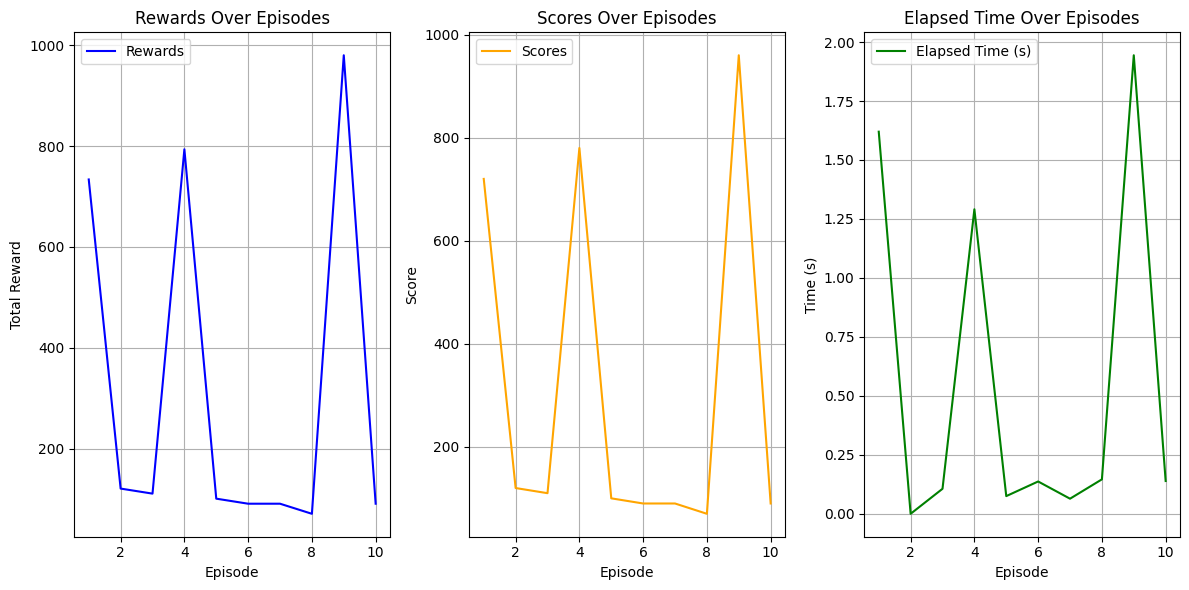

In [12]:
import matplotlib.pyplot as plt

# Create an episode index
episodes_index = list(range(1, len(rewards) + 1))

# Plotting
plt.figure(figsize=(12, 6))

# Rewards plot
plt.subplot(1, 3, 1)
plt.plot(episodes_index, rewards, label="Rewards", color="blue")
plt.title("Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()

# Scores plot
plt.subplot(1, 3, 2)
plt.plot(episodes_index, scores, label="Scores", color="orange")
plt.title("Scores Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

# Times plot
plt.subplot(1, 3, 3)
plt.plot(episodes_index, times, label="Elapsed Time (s)", color="green")
plt.title("Elapsed Time Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
model.save("brick_breaker_dqn.h5")